# SEIR Model for COVID-19 Forecasting

In [2]:
%load_ext lab_black

# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from bayes_opt import BayesianOptimization
from scipy.optimize import minimize, least_squares
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

# Other
import copy
from datetime import datetime, timedelta
import os
import random
import sys
from typing import List, Tuple

# Custom module
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join("../ygg_seir_simulator/"))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.plotting import plot_predictions
from src.utils import get_covid_data, get_all_covid_data
from ygg_seir_simulator.fixed_params import *
from ygg_seir_simulator.region_model import RegionModel
from ygg_seir_simulator.learn_simulation import *
from ygg_seir_simulator.simulation import run, predict
from ygg_seir_simulator.util import str_to_date, remove_space_region

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## Purpose

The goal is to produce accurate forecasts of COVID-19 deaths and infections in Canada. One of the models we'll be focusing on is an SEIR model using a simulator based off of https://covid19-projections.com/model-details/.  

## Load Data and EDA

For the data we'll only be using mortality data as data on active infections and new infections can be innacurate and add noise to the model. The dataset can be found here https://github.com/ishaberry/Covid19Canada.

In [3]:
# Read in data
mortality_start_date = datetime.date(day=8, month=3, year=2020)
mortality_provinces = get_all_covid_data(level="prov").query(
    "date >= @mortality_start_date"
)

# mortality_provinces = pd.read_csv(
#     "../data/timeseries_prov/mortality_timeseries_prov.csv"
# )
# active_cases_provinces = pd.read_csv(
#     "../data/timeseries_prov/active_timeseries_prov.csv"
# )

# # Simple preprocessing
# format = "%d-%m-%Y"
# mortality_provinces = mortality_provinces.assign(
#     date_death_report=lambda x: pd.to_datetime(
#         x["date_death_report"], format=format
#     ).dt.date
# ).rename(columns={"date_death_report": "date"})

# active_cases_provinces = active_cases_provinces.assign(
#     date_active=lambda x: pd.to_datetime(x["date_active"], format=format).dt.date
# ).assign(cumulative_removed=lambda x: x["cumulative_cases"] + x["cumulative_recovered"])

# Get first and last day of death reports
mortality_start_date = mortality_provinces["date"].min()
mortality_end_date = mortality_provinces["date"].max()

# Filter for Ontario
mortality_ontario = mortality_provinces.query('province == "Ontario"')

mortality_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
43  Alberta  2020-03-08                 4                     0   
44  Alberta  2020-03-09                14                     0   
45  Alberta  2020-03-10                14                     0   
46  Alberta  2020-03-11                19                     0   
47  Alberta  2020-03-12                23                     0   
48  Alberta  2020-03-13                29                     0   
49  Alberta  2020-03-14                39                     0   
50  Alberta  2020-03-15                56                     0   
51  Alberta  2020-03-16                74                     0   
52  Alberta  2020-03-17                97                     0   

    cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
43                  0             4                    2       0          0   
44                  0            14                   10       0          0   
45                  0            14                    0       0          0   
46                  0            19                    5       0          0   
47                  0            23                    4       0          0   
48                  0            29                    6       0          0   
49                  0            39                   10       0          0   
50                  0            56                   17       0          0   
51                  0            74                   18       0          0   
52                  0            97                   23       0          0   

    cases  population  removed  susceptible  percent_susceptible  
43      2     4421876        0      4421872             0.999999  
44     10     4421876        0      4421862             0.999997  
45      0     4421876        0      4421862             0.999997  
46      5     4421876        0      4421857             0.999996  
47      4     4421876        0      4421853             0.999995  
48      6     4421876        0      4421847             0.999993  
49     10     4421876        0      4421837             0.999991  
50     17     4421876        0      4421820             0.999987  
51     18     4421876        0      4421802             0.999983  
52     23     4421876        0      4421779             0.999978

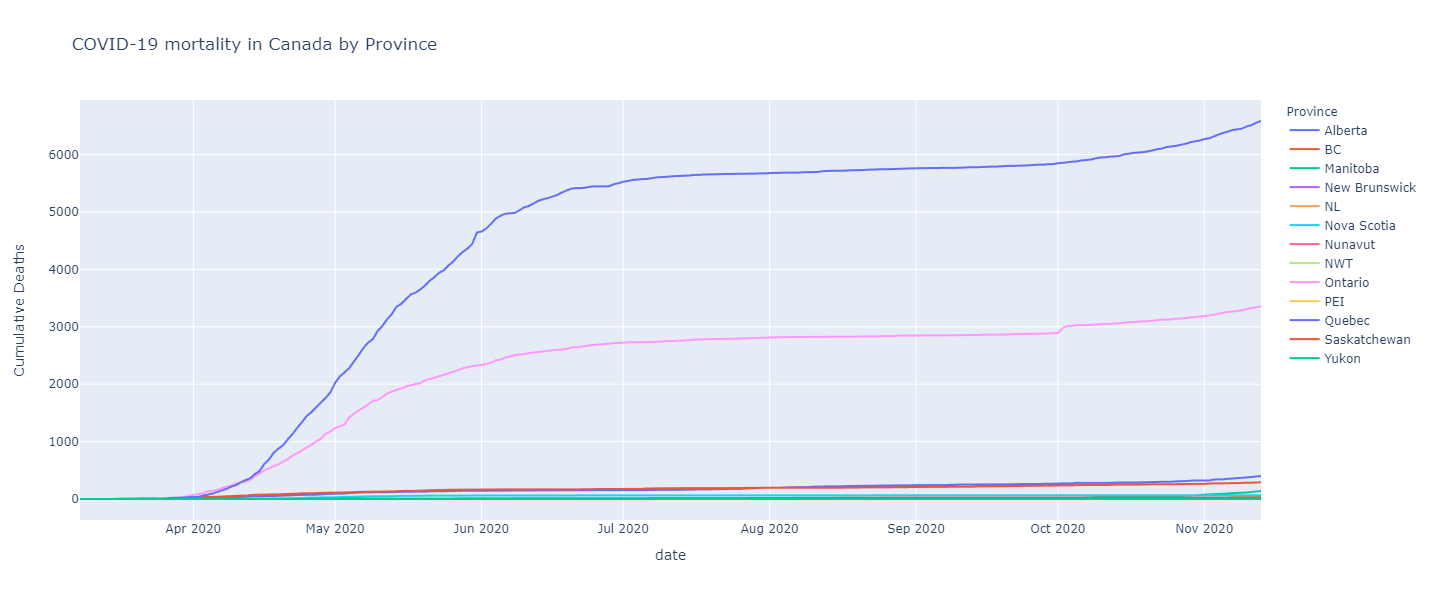

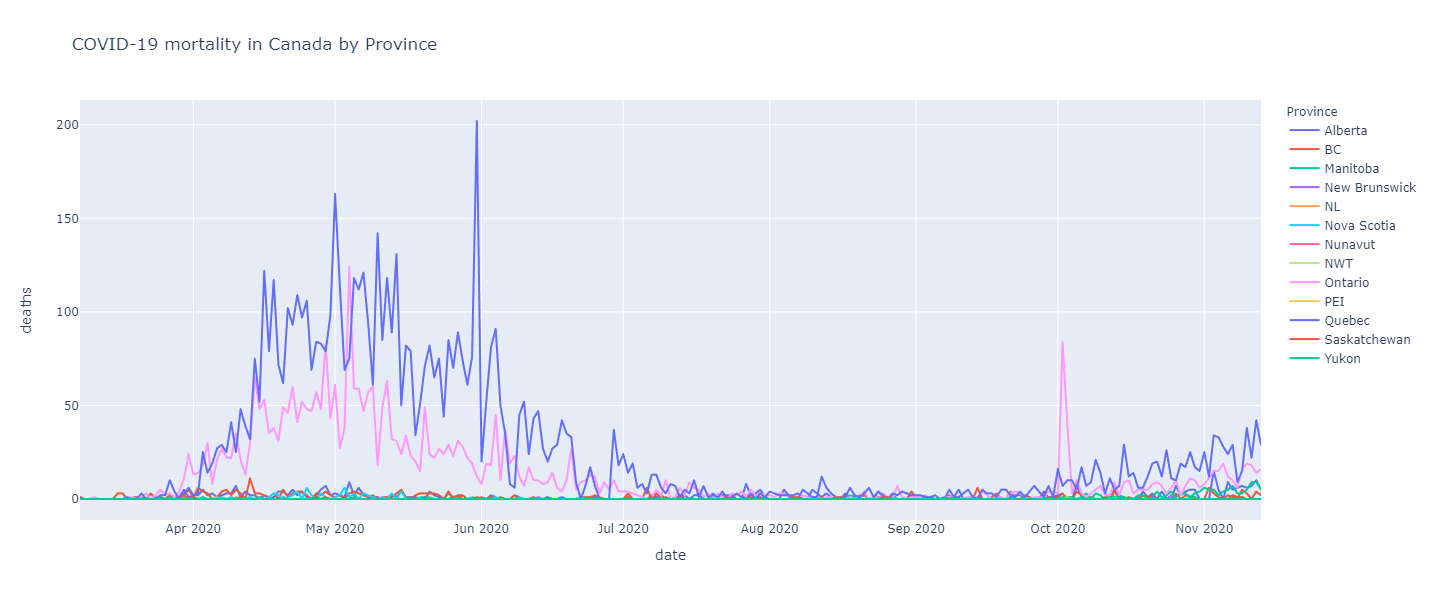

In [4]:
# Cumulative deaths
fig = px.line(
    mortality_provinces,
    x="date",
    y="cumulative_deaths",
    color="province",
    title="COVID-19 mortality in Canada by Province",
    labels=dict(
        date_death_report="Date",
        cumulative_deaths="Cumulative Deaths",
        province="Province",
    ),
    height=600,
)
fig.show()

# Daily deaths
fig = px.line(
    mortality_provinces,
    x="date",
    y="deaths",
    color="province",
    title="COVID-19 mortality in Canada by Province",
    labels=dict(
        date_death_report="Date",
        cumulative_deaths="Daily deaths",
        province="Province",
    ),
    height=600,
)
fig.show()

In [5]:
# Ignore provinces with very little cases
provinces_ignore = ["PEI", "New Brunswick", "NWT", "NL", "Nunavut", "Yukon"]
mortality_provinces = mortality_provinces.query(
    "province not in @provinces_ignore"
).reset_index(drop=True)

# Get list of provinces
provinces = mortality_provinces["province"].unique()

### Comments

- From the mortalities plot above it seems like Quebec and Ontario make up the majority of covid mortalities in Canada. They greatly increase at the start and then slow down and are currently starting to level out
- The other provinces have much lower growth in deaths. Zooming in we see a mostly linear pattern
- All the provinces have their date death reports on the same day March 8, 2020
- We will also be ignoring provinces with very few cases as they don't provide much information and predicting covid cases for those provinces is not as important as the major provinces

## SEIR Parameter Estimation

First we would want to replace the simple grid search layer in the original model with more sophisticated optimization methods. We will be fine tuning the current model and so the only parameters we'll be tuning are:

- Mortality rate
- Initial $R_0$
- Lockdown $R_0$
- Imports of positive cases per day

To handle overfitting we'll be applying cross-validation. Since we are dealing with time series we will split our data a bit differently. The data will be split into folds in order from 1 to k and for each $i$ from 1 to k we will use train the model on the first 1 to i folds and validate on the remaining folds. For our loss function we'll be using root mean squared error (RMSE) on the cumulative sum of deaths.

In each of the following estimatinon methods we'll be using Ontario data to give an example of the algorithm

In [6]:
# Set argument values
skip_hospitalizations = None
quarantine_perc = 0
quarantine_effectiveness = -1
best_params_type = "mean"
country = "Canada"
region = "ALL"
subregion = "Ontario"
best_params_dir = "../models/best_params/latest"

# Set start and end dates
simulation_start_date = mortality_start_date - timedelta(days=DAYS_BEFORE_DEATH)
simulation_create_date = datetime.date(year=2020, month=10, day=1)
simulation_end_date = mortality_provinces["date"].max() + timedelta(days=40)

# Load parameters from file. This contains both fixed and variable parameters. We will not use the given variable parameters however
region_param, params_dict = load_best_params_province(best_params_dir, "Ontario")
for variable_param in [
    "INITIAL_R_0",
    "LOCKDOWN_R_0",
    "MORTALITY_RATE",
    "DAILY_IMPORTS",
]:
    val = params_dict.pop(variable_param)

# Create base region models for each province
province_populations = (
    mortality_provinces[["province", "population"]]
    .drop_duplicates()
    .set_index("province")
    .T.to_dict("list")
)
region_models = {}

for province in provinces:
    region_models[province] = RegionModel(
        country_str=country,
        region_str=region,
        subregion_str=province,
        first_date=simulation_start_date,
        projection_create_date=simulation_create_date,
        projection_end_date=simulation_end_date,
        region_params={"population": province_populations[province][0]},
        compute_hospitalizations=(not skip_hospitalizations),
    )

# Dataframe to store cross validation scores
cv_scores = pd.DataFrame(columns=["province", "method", "fold", "rmse"])

Loading params file: ../models/best_params/latest/subregion\Canada_Ontario.json


In [7]:
def loss(
    variable_params: Tuple,
    params: dict,
    region_model: RegionModel,
    mortality_data: pd.DataFrame,
) -> float:
    """
    Helper function for calculting root mean squared error for SEIR model.
    The variable params should be (initial_r_0, lockdown_r_0, mortality_rate, daily_imports)
    """
    # Initialize parameters for region model
    (
        params["INITIAL_R_0"],
        params["LOCKDOWN_R_0"],
        params["MORTALITY_RATE"],
        params["DAILY_IMPORTS"],
    ) = variable_params
    params_tups = tuple(params.items())
    region_model_copy = copy.deepcopy(region_model)
    region_model_copy.init_params(params_tups)

    # Run SEIR simulation
    mortality_pred = predict(region_model_copy, mortality_data)

    # Calculate rmse. Use only projections for known dates and not future forecasts
    mortality_pred = mortality_pred.query("cumulative_deaths == cumulative_deaths")
    deaths_true = mortality_pred["cumulative_deaths"]
    deaths_pred = mortality_pred["cumulative_deaths_pred"]

    rmse = np.sqrt(np.mean((deaths_true - deaths_pred) ** 2))

    return rmse

### L-BFGS-B Optimization

Bound constrained minimization implemented in scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [7]:
%%time

# Estimate optimal parameters using L-BFGS-B method in scipy
x0 = [1, 1, 0.01, 100]
bounds = [(1e-4, 10), (1e-4, 10), (1e-4, 0.2 - 1e-6), (0, 1000)]

optimal = minimize(
    loss,
    x0=x0,
    args=(params_dict.copy(), region_models['Ontario'], mortality_ontario),
    method="L-BFGS-B",
    bounds=bounds,
)

Wall time: 44.9 s


In [8]:
# Initialize parameters for region_model using estimated params
params = params_dict.copy()
(
    params["INITIAL_R_0"],
    params["LOCKDOWN_R_0"],
    params["MORTALITY_RATE"],
    params["DAILY_IMPORTS"],
) = optimal.x
params_tups = tuple(params.items())
region_models["Ontario"].init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_models["Ontario"], mortality_ontario)
rmse = loss(optimal.x, params_dict.copy(), region_models["Ontario"], mortality_ontario)
print(f"rmse: {rmse}\n")

rmse: 74.13410354797631



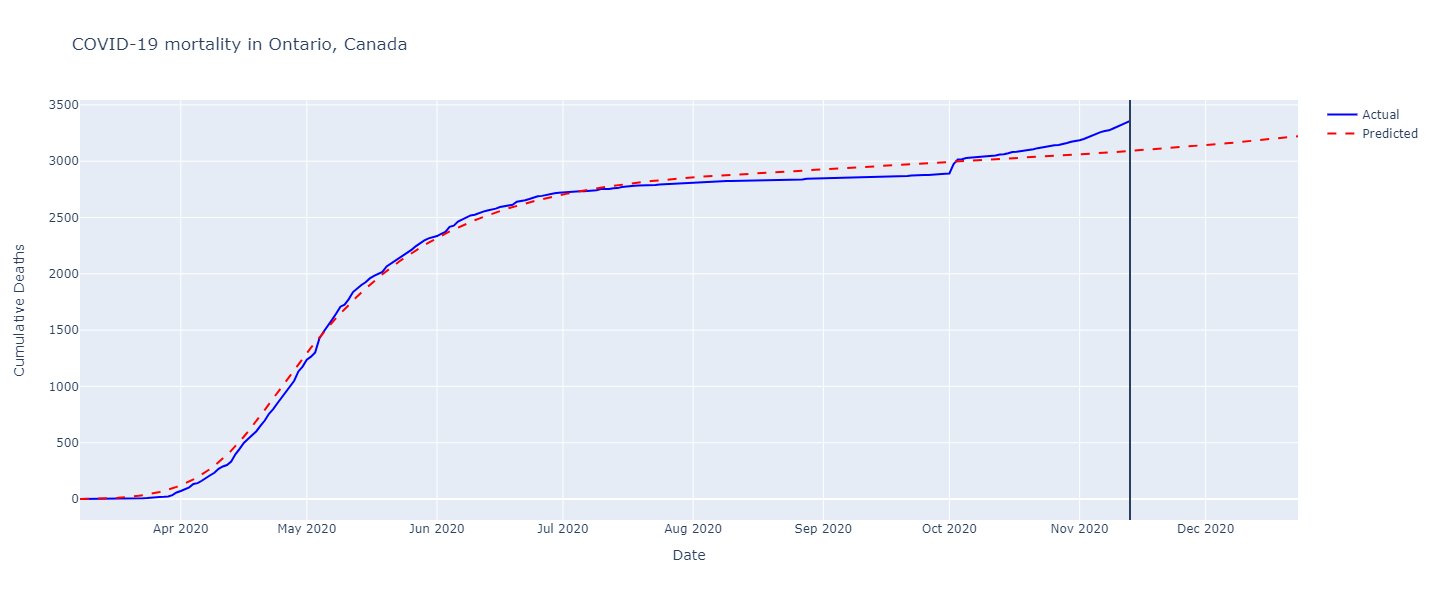

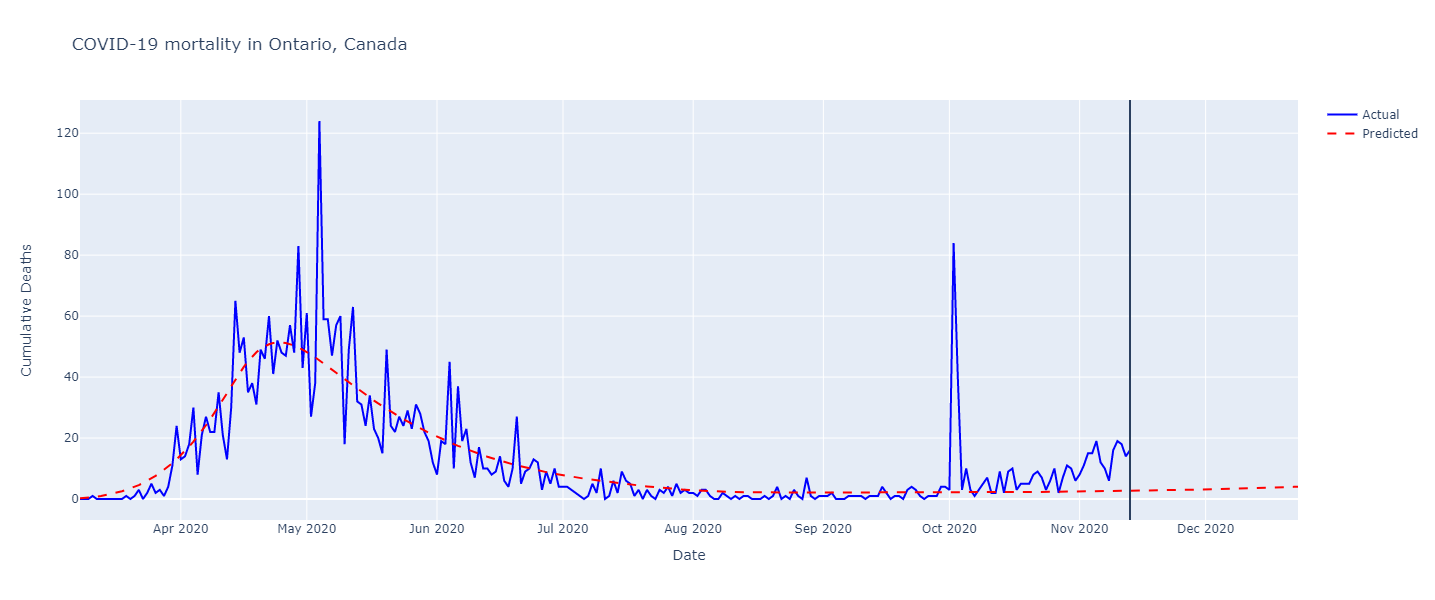

In [9]:
# Plot results for cumulative deaths
plot_predictions(
    mortality_pred,
    y="cumulative_deaths",
    y_label="Cumulative Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

# Plot results for daily deaths
plot_predictions(
    mortality_pred,
    y="deaths",
    y_label="Daily Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

#### Cross validation scores

In [10]:
%%time

tscv = TimeSeriesSplit(n_splits=10)

# loop through each province and each split
for province in provinces:
    mortality_province = mortality_provinces.query('province == @province')
    region_model = region_models[province]
    
    for index, (train_index, test_index) in enumerate(tscv.split(mortality_province)):
        mortality_train = mortality_province.iloc[train_index]
        mortality_test = mortality_province.iloc[test_index]

        # Fit model to train set
        optimal = minimize(
            loss,
            x0=x0,
            args=(params_dict.copy(), region_model, mortality_train),
            method="L-BFGS-B",
            bounds=bounds,
        )
        
        # Initialize parameters
        params = params_dict.copy()
        (
            params["INITIAL_R_0"],
            params["LOCKDOWN_R_0"],
            params["MORTALITY_RATE"],
            params["DAILY_IMPORTS"],
        ) = optimal.x
        params_tups = tuple(params.items())
        region_model.init_params(params_tups)

        # Run simulation and calculate loss
        mortality_pred = predict(region_model, train)
        mortality_pred = mortality_pred.iloc[test_index]

        rmse = mean_squared_error(mortality_test['cumulative_deaths'], mortality_pred['cumulative_deaths_pred'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'l-bfgs-b', 'fold': index, 'rmse': rmse}, ignore_index=True)
        
        
# Save results
cv_scores.to_csv("../models/seir_cross_val_scores.csv", index=False)

Wall time: 15min 18s


In [12]:
# Average rmse scores
cv_scores.groupby(["province", "method"]).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province    method         rmse                                     
                                  mean          std        min          max
0       Alberta  l-bfgs-b    37.517490    28.793069   2.687815    93.068207
1            BC  l-bfgs-b    19.089560    14.155151   4.429089    46.587007
2      Manitoba  l-bfgs-b     9.819991    19.332470   0.480500    63.263798
3   Nova Scotia  l-bfgs-b    44.203473   134.481966   0.272996   426.912050
4       Ontario  l-bfgs-b   199.307003   351.563456   8.079894  1161.976773
5        Quebec  l-bfgs-b  1005.186394  2427.984901  16.328589  7879.317789
6  Saskatchewan  l-bfgs-b     2.439638     2.599898   0.401056     8.954023

### Bayesian Optimization

Bayesian optimization as implemented in https://github.com/fmfn/BayesianOptimization

In [18]:
%%time

# Setup parameters
pbounds = {
    "initial_r_0": (1e-4, 10),
    "lockdown_r_0": (1e-4, 10),
    "mortality_rate": (1e-4, 0.2 - 1e-6),
    "daily_imports": (0, 1000),
}

optimizer = BayesianOptimization(
    f=lambda initial_r_0, lockdown_r_0, mortality_rate, daily_imports: -loss(
        (initial_r_0, lockdown_r_0, mortality_rate, daily_imports),
        params_dict.copy(),
        region_models['Ontario'],
        mortality_ontario,
    ),
    pbounds=pbounds,
    verbose=1,
)

# # Some initial guess
# optimizer.probe(
#     params={
#         "initial_r_0": 2,
#         "lockdown_r_0": 1,
#         "mortality_rate": 0.01,
#         "daily_imports": 200,
#     },
#     lazy=True,
# )

# Run optimization
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   | daily_... | initia... | lockdo... | mortal... |
-------------------------------------------------------------------------
|  2        | -1.391e+0 |  583.6    |  8.938    |  5.897    |  0.09972  |
|  3        | -6.354e+0 |  138.3    |  1.188    |  8.247    |  0.04464  |
|  8        | -5.599e+0 |  735.2    |  9.854    |  9.774    |  0.03779  |
|  9        | -2.296e+0 |  373.9    |  6.441    |  8.093    |  0.01706  |
|  25       | -4.348e+0 |  403.0    |  1.312    |  0.08035  |  0.07596  |
|  59       | -1.538e+0 |  163.0    |  0.3888   |  0.9769   |  0.1046   |
|  113      | -1.164e+0 |  195.5    |  1.067    |  0.1589   |  0.1396   |
|  128      | -391.9    |  602.1    |  0.06767  |  0.2368   |  0.12     |
|  144      | -317.7    |  599.6    |  0.07507  |  0.4692   |  0.09911  |
Wall time: 1min 59s


In [20]:
# Initialize parameters for region_model using estimated params
max_params = optimizer.max["params"]
params = params_dict.copy()
params["INITIAL_R_0"] = max_params["initial_r_0"]
params["LOCKDOWN_R_0"] = max_params["lockdown_r_0"]
params["MORTALITY_RATE"] = max_params["mortality_rate"]
params["DAILY_IMPORTS"] = max_params["daily_imports"]

params_tups = tuple(params.items())
region_models["Ontario"].init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_models["Ontario"], mortality_ontario)
rmse = -optimizer.max["target"]
print(f"rmse: {rmse}")

rmse: 317.73795997828796


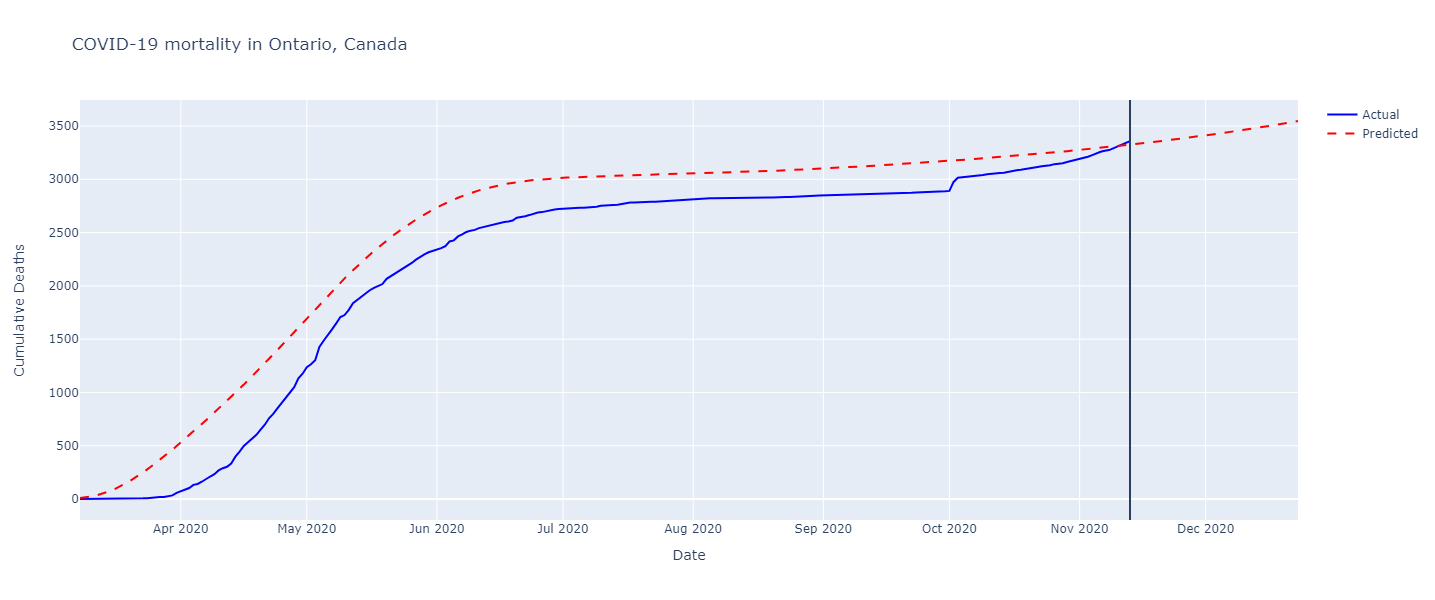

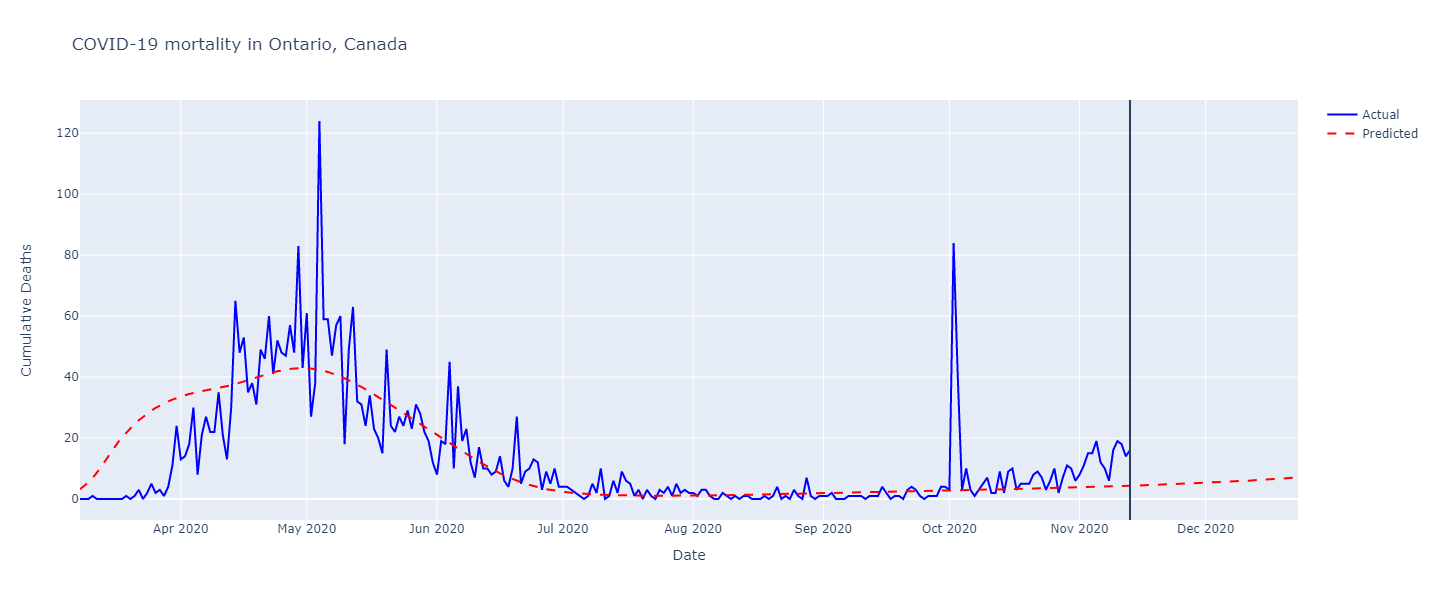

In [21]:
# Plot results for cumulative deaths
plot_predictions(
    mortality_pred,
    y="cumulative_deaths",
    y_label="Cumulative Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

# Plot results for daily deaths
plot_predictions(
    mortality_pred,
    y="deaths",
    y_label="Daily Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

#### Cross validation scores

In [28]:
%%time

tscv = TimeSeriesSplit(n_splits=10)

# loop through each province and each split
for province in provinces:
    mortality_province = mortality_provinces.query('province == @province')
    region_model = region_models[province]
    
    for index, (train_index, test_index) in enumerate(tscv.split(mortality_province)):
        mortality_train = mortality_province.iloc[train_index]
        mortality_test = mortality_province.iloc[test_index]

        # Fit model to train set
        optimizer = BayesianOptimization(
            f=lambda initial_r_0, lockdown_r_0, mortality_rate, daily_imports: -loss(
                (initial_r_0, lockdown_r_0, mortality_rate, daily_imports),
                params_dict.copy(),
                region_model,
                mortality_province,
            ),
            pbounds=pbounds,
            verbose=0,
        )
        
        # Run optimization
        optimizer.maximize(
            init_points=100,
            n_iter=100,
        )

        # Initialize parameters for region_model using estimated params
        max_params = optimizer.max["params"]
        params = params_dict.copy()
        params["INITIAL_R_0"] = max_params["initial_r_0"]
        params["LOCKDOWN_R_0"] = max_params["lockdown_r_0"]
        params["MORTALITY_RATE"] = max_params["mortality_rate"]
        params["DAILY_IMPORTS"] = max_params["daily_imports"]

        params_tups = tuple(params.items())
        region_model.init_params(params_tups)

        # Run simulation and calculate loss
        mortality_pred = predict(region_model, mortality_train)
        mortality_pred = mortality_pred.iloc[test_index]

        rmse = mean_squared_error(mortality_test['cumulative_deaths'], mortality_pred['cumulative_deaths_pred'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'bayesian_opt', 'fold': index, 'rmse': rmse}, ignore_index=True)
        
    print(f'Completed {province}')
        
# Save results
cv_scores.to_csv("../models/seir_cross_val_scores.csv", index=False)

Completed Alberta
Completed BC
Completed Manitoba
Completed Nova Scotia
Completed Ontario
Completed Quebec
Completed Saskatchewan
Wall time: 42min 26s


In [29]:
# Average rmse scores
cv_scores.query('method == "bayesian_opt"').groupby("province").agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province         rmse                                     
                        mean          std        min          max
0       Alberta   942.278658  1311.695284  39.087438  3438.335668
1            BC   656.053239  1160.177885   4.362327  3620.640034
2      Manitoba   559.900077   847.857701  22.841441  2377.770482
3   Nova Scotia  1011.276278   812.282308   8.689488  2262.157226
4       Ontario   887.550153  1220.704595  86.626106  4231.039699
5        Quebec  1078.231463  1433.668126  85.803672  4830.467099
6  Saskatchewan   820.747608  1146.077622   4.095452  2564.481035

### Grid search

Similar to the original ygg implementation we will apply a simple grid search in combination with cross validation to estimate the model parameters.

In [9]:
def estimate_params_grid(
    params_dict: dict,
    region_model,
    mortality_data: pd.DataFrame,
) -> dict:

    # Create grid of model parameters
    param_grid = {
        "INITIAL_R_0": np.linspace(0.5, 2, num=10),
        "LOCKDOWN_R_0": np.linspace(0.5, 2, num=10),
        "MORTALITY_RATE": np.geomspace(1e-4, 0.2, num=10, endpoint=False),
        "DAILY_IMPORTS": np.linspace(0, 250, num=10),
    }
    param_list = list(ParameterGrid(param_grid))

    # Run model with each set of parameters and keep track of best one
    best_rmse = np.Inf
    best_params = None

    for param in param_list:
        variable_params = (
            param["INITIAL_R_0"],
            param["LOCKDOWN_R_0"],
            param["MORTALITY_RATE"],
            param["DAILY_IMPORTS"],
        )
        rmse = loss(variable_params, params_dict.copy(), region_model, mortality_data)
        if rmse < best_rmse:
            best_rmse = rmse
            best_param = param

    return best_rmse, best_param

In [11]:
# Estimate parameters on train set
rmse, params = estimate_params_grid(
    params_dict.copy(), region_models["Ontario"], mortality_ontario
)

# Initialize parameters for region model using estimated params
params_tups = tuple({**params_dict.copy(), **params}.items())
region_models["Ontario"].init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_models["Ontario"], mortality_ontario)
print(f"rmse: {rmse}")

rmse: 90.71652376805756


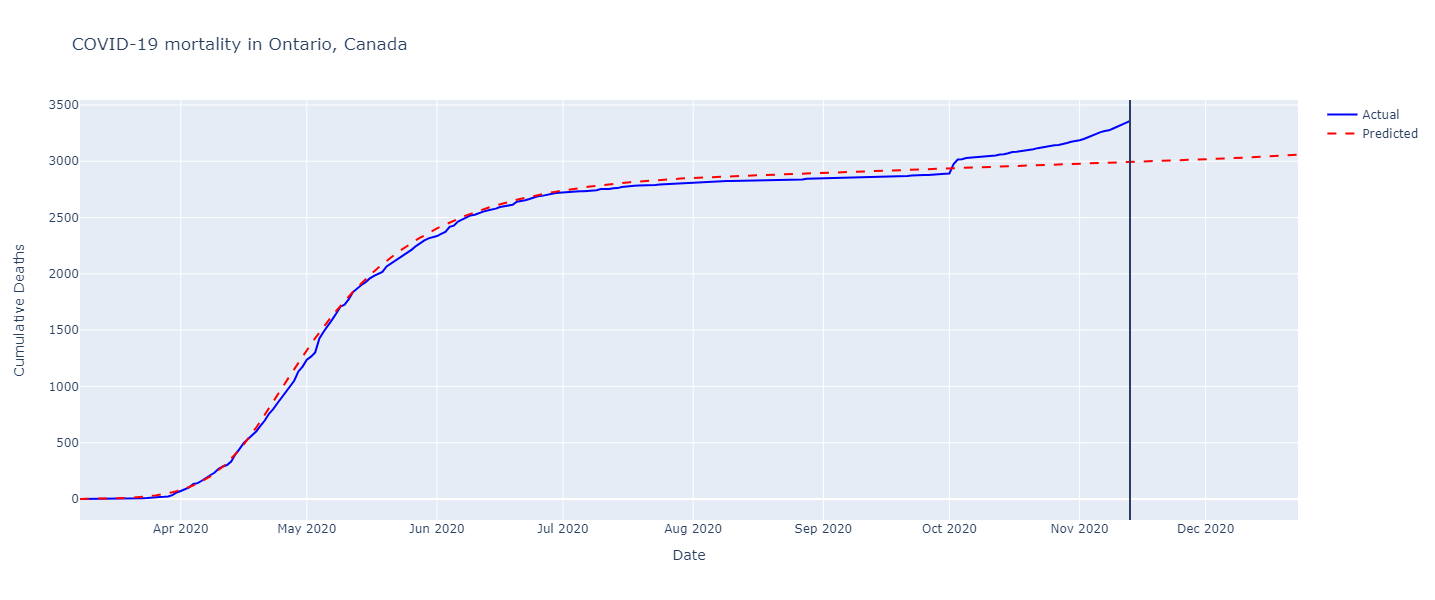

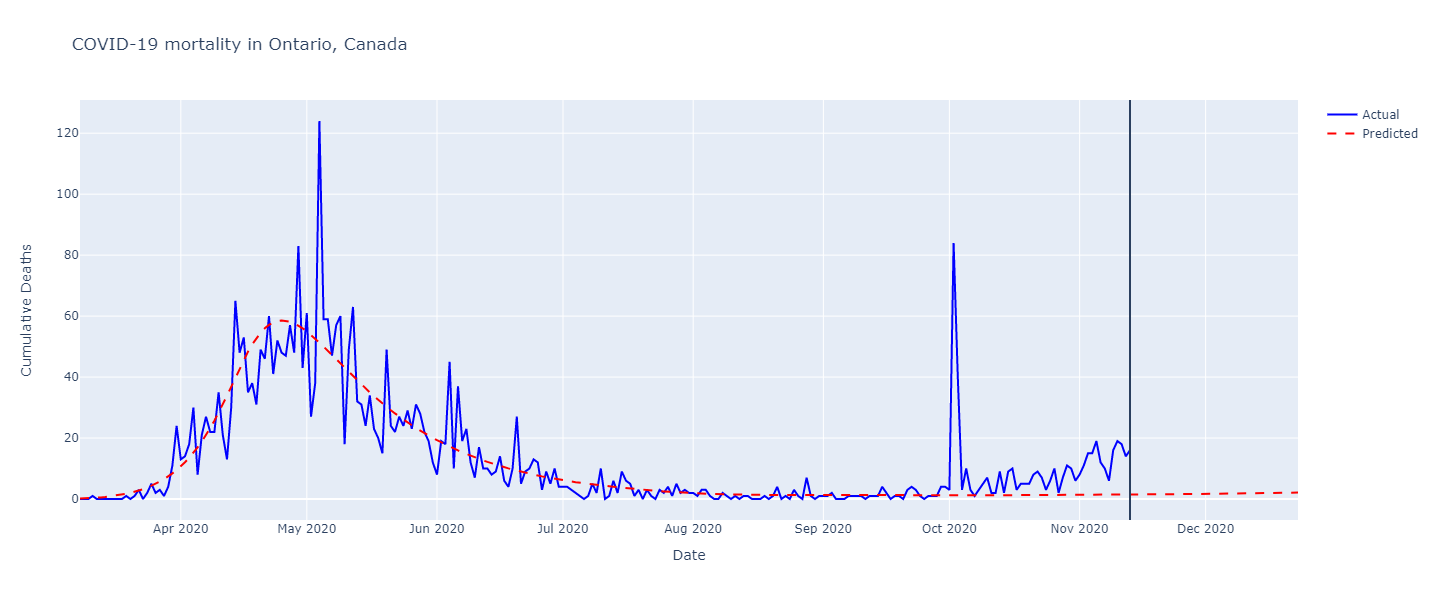

In [12]:
# Plot results for cumulative deaths
plot_predictions(
    mortality_pred,
    y="cumulative_deaths",
    y_label="Cumulative Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

# Plot results for daily deaths
plot_predictions(
    mortality_pred,
    y="deaths",
    y_label="Daily Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

#### Cross validation scores

In [13]:
%%time

tcsv = TimeSeriesSplit(n_splits=10)

# Loop through each province and each split, and also each set of parameters in the grid
for province in provinces:
    mortality_province = mortality_provinces.query('province == @province')
    region_model = region_models[province]
    
    for index, (train_index, test_index) in enumerate(tcsv.split(mortality_province)):
        mortality_train = mortality_province.iloc[train_index]
        mortality_test = mortality_province.iloc[test_index]

        # Estimate parameters on train set
        rmse, params = estimate_params_grid(params_dict.copy(), region_model, mortality_train)
        
        # Initialize parameters for region model using estimated params
        params_tups = tuple({**params_dict.copy(), **params}.items())
        region_model.init_params(params_tups)

        # Run simulation and calculate loss
        mortality_pred = predict(region_model, mortality_train)
        mortality_pred = mortality_pred.iloc[test_index]

        rmse = mean_squared_error(mortality_test['cumulative_deaths'], mortality_pred['cumulative_deaths_pred'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'grid_search', 'fold': index, 'rmse': rmse}, ignore_index=True)
        
    print(f'Completed {province}')
    
# Save results
cv_scores.to_csv("../models/seir_cross_val_scores.csv", index=False)

Completed Alberta
Completed BC
Completed Manitoba
Completed Nova Scotia
Completed Ontario
Completed Quebec
Completed Saskatchewan
Wall time: 4h 5s


In [14]:
# Average rmse scores
cv_scores.query('method == "grid_search"').groupby(["province", "method"]).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province       method        rmse                                    
                                    mean         std         min         max
0       Alberta  grid_search   43.700023   36.505732    6.360696  131.581278
1            BC  grid_search   12.020700    8.062119    1.528172   31.594257
2      Manitoba  grid_search   11.060998   20.503069    0.447684   67.386503
3   Nova Scotia  grid_search   20.730453   46.194427    0.695336  151.749660
4       Ontario  grid_search  154.040918  171.960628   38.014849  551.077332
5        Quebec  grid_search  458.251835  214.377748  197.700107  837.754573
6  Saskatchewan  grid_search    4.150702    4.450750    0.715953   15.835470

### Least squares

Based on the paper https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0230405 which applies the same methodology using an SIRD simulator.

In [26]:
# %%time

# # Estimate optimal parameters using L-BFGS-B method in scipy
# x0 = [1, 1, 0.01, 100]
# bounds = [(1e-4, 10), (1e-4, 10), (1e-4, 0.2 - 1e-6), (0, 1000)]

# ## TODO:  Missing jacobian
# least_squares(loss, x0, bounds, method='lm', args = (params_dict.copy(), region_model, mortality_ontario))

#### Cross validation scores

### Optimization method comparison

Now that we have computed the cross validation scores for all methods let's compare them and determine which optimization method performs the best

In [15]:
# Average rmse scores
cv_scores.groupby(["province", "method"]).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province        method         rmse                           \
                                       mean          std         min   
0        Alberta  bayesian_opt   942.278658  1311.695284   39.087438   
1        Alberta   grid_search    43.700023    36.505732    6.360696   
2        Alberta      l-bfgs-b    37.517490    28.793069    2.687815   
3             BC  bayesian_opt   656.053239  1160.177885    4.362327   
4             BC   grid_search    12.020700     8.062119    1.528172   
5             BC      l-bfgs-b    19.089560    14.155151    4.429089   
6       Manitoba  bayesian_opt   559.900077   847.857701   22.841441   
7       Manitoba   grid_search    11.060998    20.503069    0.447684   
8       Manitoba      l-bfgs-b     9.819991    19.332470    0.480500   
9    Nova Scotia  bayesian_opt  1011.276278   812.282308    8.689488   
10   Nova Scotia   grid_search    20.730453    46.194427    0.695336   
11   Nova Scotia      l-bfgs-b    44.203473   134.481966    0.272996   
12       Ontario  bayesian_opt   887.550153  1220.704595   86.626106   
13       Ontario   grid_search   154.040918   171.960628   38.014849   
14       Ontario      l-bfgs-b   199.307003   351.563456    8.079894   
15        Quebec  bayesian_opt  1078.231463  1433.668126   85.803672   
16        Quebec   grid_search   458.251835   214.377748  197.700107   
17        Quebec      l-bfgs-b  1005.186394  2427.984901   16.328589   
18  Saskatchewan  bayesian_opt   820.747608  1146.077622    4.095452   
19  Saskatchewan   grid_search     4.150702     4.450750    0.715953   
20  Saskatchewan      l-bfgs-b     2.439638     2.599898    0.401056   

                 
            max  
0   3438.335668  
1    131.581278  
2     93.068207  
3   3620.640034  
4     31.594257  
5     46.587007  
6   2377.770482  
7     67.386503  
8     63.263798  
9   2262.157226  
10   151.749660  
11   426.912050  
12  4231.039699  
13   551.077332  
14  1161.976773  
15  4830.467099  
16   837.754573  
17  7879.317789  
18  2564.481035  
19    15.835470  
20     8.954023

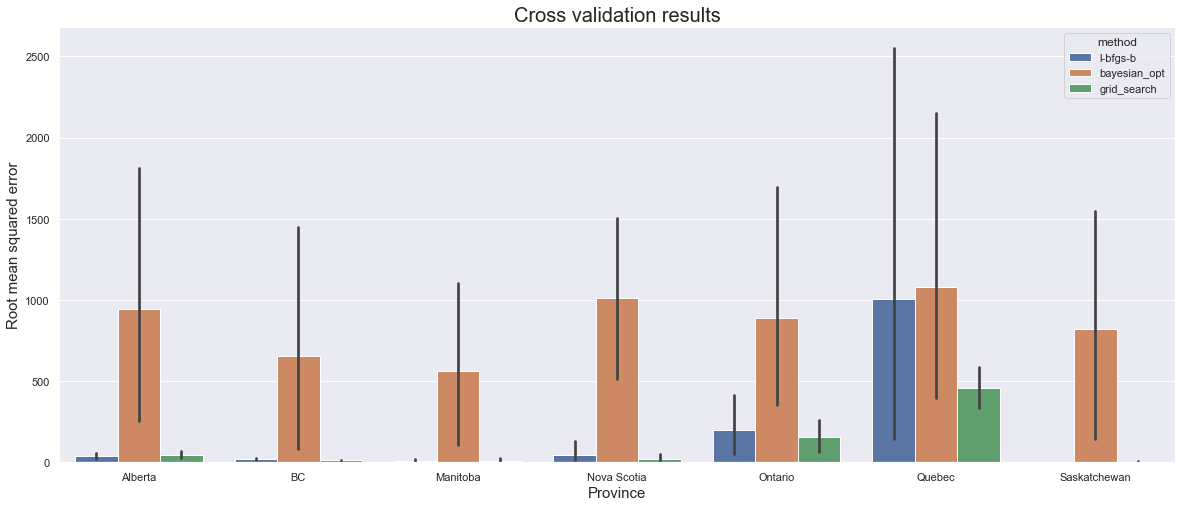

In [16]:
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="province", y="rmse", hue="method", data=cv_scores)
t = ax.set_title("Cross validation results", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

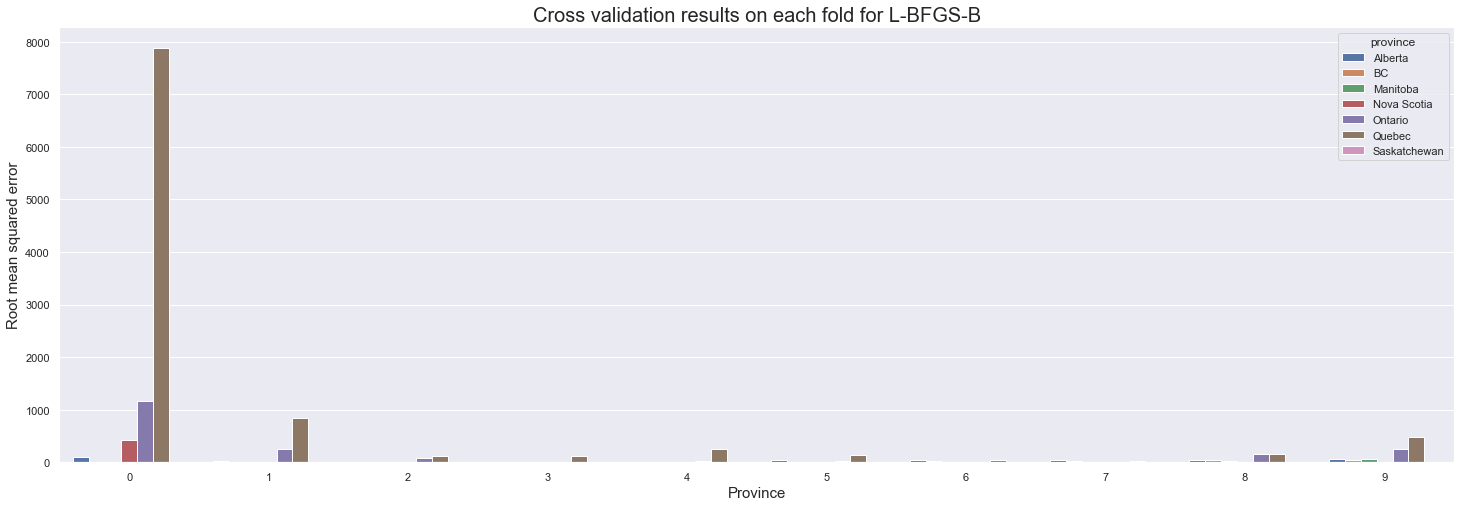

In [17]:
fig = plt.figure(figsize=(25, 8))
ax = sns.barplot(
    x="fold", y="rmse", hue="province", data=cv_scores.query('method == "l-bfgs-b"')
)
t = ax.set_title("Cross validation results on each fold for L-BFGS-B", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

### Comments on SEIR Parameter Estimation

- The bounded constrained minimization using L-BFGS-B performs fairly well and is able to capture the pattern of the disease well. It also gives much lower cross validated mean rmse scores in comparison to the other two optimization algorithms.
- Bayesian optimization does not perform too well and clearly is missing the actual curve of cumulative deaths. As well, the variance in the bayesian optimization algorithm is much too high as two different runs on the same dataset can produce massively different results and so it is not stable. We will not be using this in our final model however no harm in testing it out.
- **Note** - Cross validation results are most likely overestimates of the true testing error as the errors from first few folds will likely be fairly high as there is data to fit the model on
- Quebec has fairly high rmse score on folds 4-5 which is most likely from the large spike in deaths in Quebec during May.

## Final model results

For our final model we'll be using SEIR parameter estimation with the L-BGFS-B algorithm.

In [ ]:
# Fit model to all provinces

mortality_pred_provinces = pd.DataFrame()

# Estimate optimal parameters using L-BFGS-B method in scipy
x0 = [1, 1, 0.01, 100]
bounds = [(1e-4, 10), (1e-4, 10), (1e-4, 0.2 - 1e-6), (0, 1000)]

for province in provinces:
    region_model = region_models[province]
    mortality_province = mortality_provinces.query("province == @province")

    # Fit model to train set
    optimal = minimize(
        loss,
        x0=x0,
        args=(params_dict.copy(), region_model, mortality_province),
        method="L-BFGS-B",
        bounds=bounds,
    )

    # Initialize parameters
    params = params_dict.copy()
    (
        params["INITIAL_R_0"],
        params["LOCKDOWN_R_0"],
        params["MORTALITY_RATE"],
        params["DAILY_IMPORTS"],
    ) = optimal.x
    params_tups = tuple(params.items())
    region_model.init_params(params_tups)

    # Get predictions and append results
    mortality_pred = predict(region_model, mortality_province)
    mortality_pred_provinces = mortality_pred_provinces.append(
        mortality_pred, ignore_index=True
    )

In [ ]:
# Plot forecasts for all provinces
for province in provinces:
    mortality_pred = mortality_pred_provinces.query("province == @province")

    # Plot results for cumulative deaths
    plot_predictions(
        mortality_pred,
        y="cumulative_deaths",
        y_label="Cumulative Deaths",
        title=f"COVID-19 mortality in {province}, Canada",
        height=600,
    )

    # Plot results for daily deaths
    plot_predictions(
        mortality_pred,
        y="deaths",
        y_label="Daily Deaths",
        title=f"COVID-19 mortality in {province}, Canada",
        height=600,
    )

### Comments

- Most SEIR models seem to fit the actual curve fairly well up to October where there is an increased amount of daily deaths which the SEIR model isn't able to take it into account as the death/recovered compartment tends to level out. This is most likely due to the opening of Stage 3 which caused a spike in covid cases and leaded to going back to Stage 2. Similar to the Initial R_0 and Lockdown R_0 values, the assumption of constant R_0 value past social distancing does not seem too appropriate.
- Looking back at the mortality data for provinces it does not seem necessary to have model for Nova Scotia and Saskatchewan and possibly Manitoba as they don't have high cumulative deaths. This leaves only the 4 provinces Alberta, British Columbia, Ontario, and Quebec.

## Confidence Intervals